<a href="https://colab.research.google.com/github/escapingLife/mashinePrograming/blob/master/10%EC%A3%BC%EC%B0%A8/CNN%2BLSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# ===================================================================
# UCI HAR Dataset - CNN + LSTM 하이브리드 모델 (고성능)
# ===================================================================

import numpy as np
import pandas as pd
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, BatchNormalization, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import os

# -----------------------------------------------------------
# 데이터 로드 관련 함수
# -----------------------------------------------------------
def load_file(filepath):
    dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values

def load_group(filenames, prefix=''):
    loaded = []
    for name in filenames:
        data = load_file(os.path.join(prefix, name))
        loaded.append(data)
    loaded = np.dstack(loaded)
    return loaded

def load_dataset_group(group, dataset_path):
    signals_path = os.path.join(dataset_path, group, 'Inertial Signals')
    filenames = [
        'total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt',
        'body_acc_x_'+group+'.txt',  'body_acc_y_'+group+'.txt',  'body_acc_z_'+group+'.txt',
        'body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt'
    ]
    X = load_group(filenames, signals_path)
    y = load_file(os.path.join(dataset_path, group, 'y_'+group+'.txt'))
    return X, y

def load_dataset(dataset_path):
    trainX, trainy = load_dataset_group('train', dataset_path)
    testX, testy = load_dataset_group('test', dataset_path)

    trainy = trainy - 1
    testy = testy - 1

    trainy_one_hot = to_categorical(trainy)
    testy_one_hot = to_categorical(testy)

    print(f"trainX: {trainX.shape}, trainy: {trainy.shape}")
    print(f"testX: {testX.shape}, testy: {testy.shape}")
    return trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot

# -----------------------------------------------------------
# 데이터 로드
# -----------------------------------------------------------
dataset_path = r"/content/drive/MyDrive/Colab Notebooks/UCI HAR Dataset"
trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot = load_dataset(dataset_path)

/tmp/ipython-input-93589903.py:23: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp/ipython-input-93589903.py:23: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp/ipython-input-93589903.py:23: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp/ipython-input-93589903.py:23: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp

trainX: (7352, 128, 9), trainy: (7352, 1)
testX: (2947, 128, 9), testy: (2947, 1)


In [3]:
# -----------------------------------------------------------
# train 데이터를 train/validation으로 분리
# -----------------------------------------------------------
X_train, X_val, y_train_one_hot, y_val_one_hot, y_train, y_val = train_test_split(
    trainX, trainy_one_hot, trainy, test_size=0.2, random_state=100
)

print("\n데이터 분할 결과:")
print("X_train:", X_train.shape, "X_val:", X_val.shape)
print("y_train_one_hot:", y_train_one_hot.shape, "y_val_one_hot:", y_val_one_hot.shape)


데이터 분할 결과:
X_train: (5881, 128, 9) X_val: (1471, 128, 9)
y_train_one_hot: (5881, 6) y_val_one_hot: (1471, 6)


In [4]:
# -----------------------------------------------------------
# 스케일링
# -----------------------------------------------------------
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.reshape(-1, X_train.shape[2])).reshape(X_train.shape)
X_val_scaled   = scaler.transform(X_val.reshape(-1, X_val.shape[2])).reshape(X_val.shape)
testX_scaled   = scaler.transform(testX.reshape(-1, testX.shape[2])).reshape(testX.shape)

In [5]:
# -----------------------------------------------------------
# 입력/출력 차원
# -----------------------------------------------------------
n_timesteps, n_features, n_outputs = X_train_scaled.shape[1], X_train_scaled.shape[2], y_train_one_hot.shape[1]

In [6]:
# -----------------------------------------------------------
# CNN + LSTM 하이브리드 모델 정의
# -----------------------------------------------------------
cnn_lstm_model = Sequential([
    # --- CNN 블록 ---
    Conv1D(128, kernel_size=7, activation='relu', input_shape=(n_timesteps, n_features)),
    BatchNormalization(),
    Dropout(0.3),

    Conv1D(256, kernel_size=5, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    # --- LSTM 블록 ---
    LSTM(128, return_sequences=False),
    BatchNormalization(),
    Dropout(0.4),

    # --- 완전 연결층 ---
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(n_outputs, activation='softmax')
])

cnn_lstm_model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=1e-4),
    metrics=['accuracy']
)

cnn_lstm_model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 122, 128)       │         8,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 122, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 122, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 118, 256)       │       164,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 118, 256)       │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 118, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 128)            │       197,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 388,742 (1.48 MB)

 Trainable params: 387,718 (1.48 MB)

 Non-trainable params: 1,024 (4.00 KB)

In [7]:
# -----------------------------------------------------------
# 조기 종료
# -----------------------------------------------------------
es = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

In [8]:
# -----------------------------------------------------------
# 학습
# -----------------------------------------------------------
history = cnn_lstm_model.fit(
    X_train_scaled, y_train_one_hot,
    epochs=100,
    batch_size=64,
    validation_data=(X_val_scaled, y_val_one_hot),
    callbacks=[es],
    verbose=1
)

Epoch 1/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - accuracy: 0.4326 - loss: 1.5449 - val_accuracy: 0.7118 - val_loss: 1.1489
Epoch 2/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.7083 - loss: 0.7186 - val_accuracy: 0.7913 - val_loss: 0.6614
Epoch 3/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.7599 - loss: 0.6038 - val_accuracy: 0.8572 - val_loss: 0.4135
Epoch 4/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.8272 - loss: 0.4523 - val_accuracy: 0.8858 - val_loss: 0.2922
Epoch 5/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.8569 - loss: 0.3778 - val_accuracy: 0.9164 - val_loss: 0.2221
Epoch 6/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.8851 - loss: 0.3174 - val_accuracy: 0.9388 - val_loss: 0.1600
Epoch 7/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.9064 - loss: 0.2512 - val_accuracy: 0.9402 - val_loss: 0.1484
Epoch 8/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.9221 - loss: 0.2191 - val_accuracy: 0

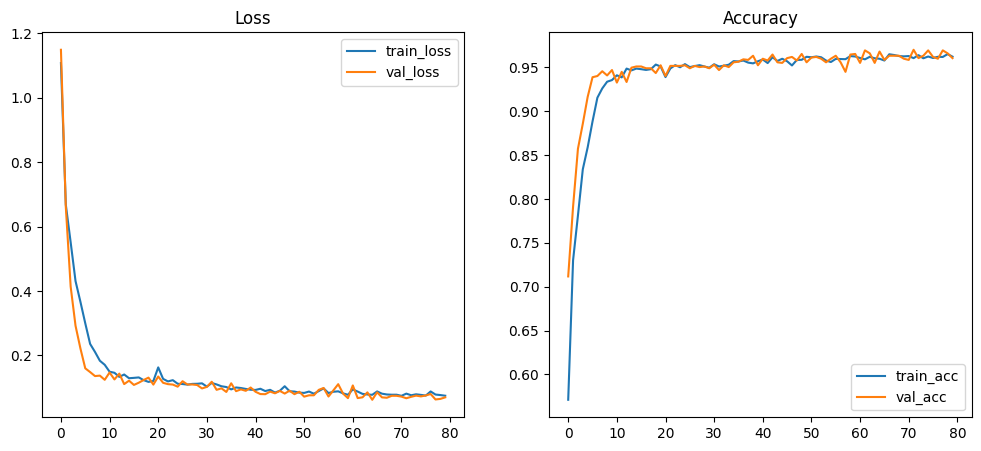

In [11]:
# -----------------------------------------------------------
# 손실/정확도 시각화
# -----------------------------------------------------------
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.title('Accuracy')
plt.legend()
plt.show()


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
Test Accuracy: 92.64 %
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       496
           1       0.95      0.95      0.95       471
           2       0.95      0.99      0.97       420
           3       0.82      0.80      0.81       491
           4       0.86      0.83      0.85       532
           5       0.99      1.00      0.99       537

    accuracy                           0.93      2947
   macro avg       0.93      0.93      0.93      2947
weighted avg       0.93      0.93      0.93      2947



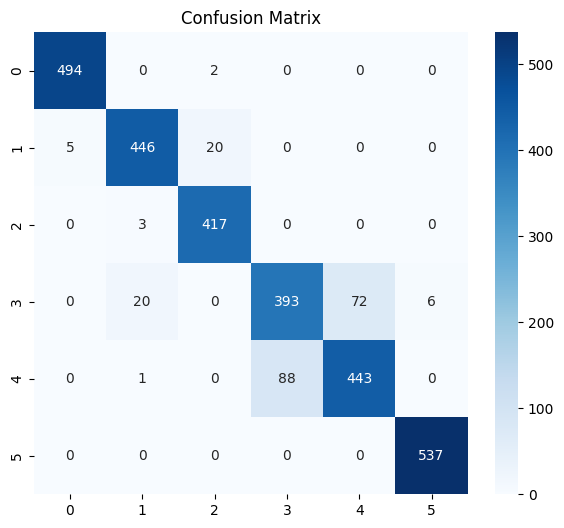

In [12]:
# -----------------------------------------------------------
# 테스트 평가
# -----------------------------------------------------------
pred = cnn_lstm_model.predict(testX_scaled)
pred_classes = np.argmax(pred, axis=1)

cm = confusion_matrix(testy, pred_classes)
acc = accuracy_score(testy, pred_classes)

print(f"Test Accuracy: {acc * 100:.2f} %")
print(classification_report(testy, pred_classes))

plt.figure(figsize=(7,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.show()